<a href="https://colab.research.google.com/github/ShrRa/UNG_OpenDay_ConvDemo/blob/main/ConvolutionDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# For opening in Google Colab
#!pip install jupyter_bokeh

In [96]:
import panel as pn
import holoviews as hv
from holoviews import opts
import cv2
import time
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pn.extension()

In [3]:
from bokeh.resources  import settings

#settings.resources = 'inline'

### Files and directories

In [4]:
image_paths = {
    'Image 1': './images/image_1.jpg',
    'Image 2': './images/image_2.jpg',
    'Image 3': './images/image_3.jpg'
}

In [5]:
kernels = {
    'vertical': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    'horizontal': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    'laplacian': np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
}

### Functions

In [7]:
# Function to select source image
def select_source_image(event):
    image_path = image_paths[selector_image.value]
    try:
        #image = hv.RGB.load_image(image_path).opts(opts.RGB(width=400, height=300))
        #image = Image.new('RGB', (400, 300), color='white')
        image = Image.open(image_path)
        #image = image.resize((400, 300))
        pane_source_image.object = image
    except Exception as e:
        print(f"Error loading image: {e}")
        pane_source_image.object = hv.Text(0, 0, f"Error loading {image_path}")

In [8]:
# Function to convolve the source image
def convolve_image(image_path, kernel_type):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("Error: Could not load image at", image_path)
            return None
        if kernel_type not in kernels.keys():
            print("Error: Invalid kernel type.")
            return None
        kernel = kernels[kernel_type]
        convolved_img = Image.fromarray(cv2.filter2D(img, -1, kernel))
        return convolved_img
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [9]:
# Function to reveal convolution image patch by patch
def reveal_convolution(event):
    print('clicked')
    try:
        image_path = image_paths[selector_image.value]
        kernel_type = selector_kernel.value
        convolved_img = convolve_image(image_path, kernel_type)

        width, height = convolved_img.size
        #part_width = int(0.1 * width)
        #part_height = int(0.1 * height)
        part_width = 3
        part_height = 3
        revealed_image = Image.new('RGB', (width, height), color='gray')

        for i in range(0, height, part_height):
            for j in range(0, width, part_width):
                part = convolved_img.crop((j, i, min(j + part_width, width), min(i + part_height, height)))
                revealed_image.paste(part, (j, i))
                pane_convolved_image.object = revealed_image
                time.sleep(0.005)
    except Exception as e:
        print(f"Error revealing image: {e}")
        pane_convolved_image.object = "Error revealing image."

### Layout

In [6]:
from PIL import Image

In [7]:
def arr_to_img(kernel):
    fig, ax = plt.subplots(1,1)
    ax.imshow(kernel, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    return fig

In [36]:
# Create image panes
kernel_panes = {
    name: pn.pane.Image(object=arr_to_img(kernel), width=100, height=100,styles={'opacity':'0.5'})
    for name, kernel in kernels.items()
}

# Create the toggle group
selector_kernel = pn.widgets.RadioButtonGroup(name="Select Kernel", options=list(kernel_panes.keys()), button_type='primary',align='center')

# Function to update the displayed images
def update_kernels(event):
    active_image = selector_kernel.value
    for name, pane in kernel_panes.items():
        if name == active_image:
            pane.styles = {'opacity':'1'} 
        else:
            pane.styles = {'opacity':'0.5'}

selector_kernel.param.watch(update_kernels, 'value')


Watcher(inst=RadioButtonGroup(align='center', button_type='primary', name='Select Kernel', options=['vertical', 'horizontal',...], value='vertical'), cls=<class 'panel.widgets.select.RadioButtonGroup'>, fn=<function update_kernels at 0x7dc4da530f40>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False, precedence=0)

In [116]:
log = []

In [193]:
def load_orig_img(event):
    image_path = file_selector.value[0]
    log.append(image_path)
    try:
        #image = hv.RGB.load_image(image_path).opts(opts.RGB(width=400, height=300))
        #image = Image.new('RGB', (400, 300), color='white')
        image = Image.open(image_path)
        #image = image.resize((400, 300))
        orig_img_pane.object = image
        orig_img_pane_step.object = image
        conv_img_pane.object = Image.new('RGB', image.size, color='gray')
        conv_img_pane_step.object = Image.new('RGB', image.size, color='gray')
        x_slider.end = image.width-3
        y_slider.end = image.height-3
        x_slider.value = image.width//2
        y_slider.value = image.height//2
    except Exception as e:
        print(f"Error loading image: {e}")
        orig_img_pane.object = hv.Text(0, 0, f"Error loading {image_path}")
    return

In [194]:
def select_kernel(event):
    active_image = radio_group.value
    for name, pane in kernel_panes.items():
        if name == active_image:
            pane.styles = {'opacity':'1'} 
        else:
            pane.styles = {'opacity':'0.5'}
    return

In [195]:
def convolve_image(image_path, kernel):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            log.append("Error: Could not load image")
            return None
 
        convolved_img = Image.fromarray(cv2.filter2D(img, -1, kernel))
        return convolved_img
    except Exception as e:
        log.append(f"An error occurred: {e}")
        return None
    return

In [211]:
def start_convolution(event):
    log.append('start')
    try:
        image_path = file_selector.value[0]
        log.append(image_path)
        kernel = kernels[selector_kernel.value]
        log.append(selector_kernel.value)
        convolved_img = convolve_image(image_path, kernel)
        log.append('conv good')

        width, height = convolved_img.size
        part_width = 3
        part_height = 3
        revealed_image = Image.new('RGB', (width, height), color='gray')
        log.append('conv image object created')
        for i in range(0, height, part_height):
            for j in range(0, width, part_width): 
                part = convolved_img.crop((j, i, min(j + part_width, width), min(i + part_height, height)))
                revealed_image.paste(part, (j, i))
                conv_img_pane.object = revealed_image
                time.sleep(0.005)
    except Exception as e:
        log.append(f"Error revealing image: {e}")        
    return

In [208]:
def draw_rec(event):
    try:
        #load_orig_img(event)
        #img = Image.new('RGB', orig_img_pane.object.size, color='gray')
        #img.paste(orig_img_pane.object)
        img = orig_img_pane.object
        log.append('draw_rec start')
        draw = ImageDraw.Draw(img)
        x_coord = x_slider.value
        y_coord = y_slider.value
        (width, height) = orig_img_pane.object.size
        log.append('draw_rec got coords')
        draw.rectangle([(x_coord, y_coord), (x_coord+30, y_coord+30)], outline='red', width=3)
        log.append('draw_rec works')
        orig_img_pane_step.object = img
        log.append('orig_img_pane_step updated')
        part_width, part_height = 3, 3
        part = orig_img_pane.object.crop((x_coord, y_coord, min(x_coord + part_width, width), min(y_coord + part_height, height)))
        img_part_pane.object = part.resize(img_part_pane.object.size)
    except Exception as e:
        log.append(f"Error drawing on image: {e}")

### Common

In [214]:
file_selector = pn.widgets.FileSelector()
file_selector.param.watch(load_orig_img, 'value')

Watcher(inst=FileSelector(), cls=<class 'panel.widgets.file_selector.FileSelector'>, fn=<function load_orig_img at 0x7dc4c1544ae0>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False, precedence=0)

In [236]:
pic_plus = pn.pane.SVG('./icons/plus.svg',height=60,align='center')
pic_eq = pn.pane.SVG('./icons/eq.svg',height=60,align='center')

### Rapid convolution

In [237]:
kernel_selector = pn.Column(
    selector_kernel,
    pn.Row(
        *kernel_panes.values()
    ), align='center'
)
convolve_button = pn.widgets.Button(name="Start convolution",button_type='primary')
convolve_button.on_click(start_convolution)
orig_img_pane = pn.pane.Image(object=Image.new('RGB', (400, 300), color='gray'))
conv_img_pane = pn.pane.Image(object=Image.new('RGB', (400, 300), color='gray'))
conv_rapid = pn.Column(kernel_selector,convolve_button,pn.Row(orig_img_pane,conv_img_pane),name='Quick convolution')

### Step by step

In [238]:
orig_img_pane_step = pn.pane.Image(object=Image.new('RGB', (400, 300), color='gray'))
conv_img_pane_step = pn.pane.Image(object=Image.new('RGB', (400, 300), color='gray'))
img_part_pane = pn.pane.Image(object=Image.new('RGB', (100, 100), color='gray'))
kernel_pane = pn.pane.Image(object=Image.new('RGB', (100, 100), color='gray'))
conv_part_pane = pn.pane.Image(object=Image.new('RGB', (100, 100), color='gray'),align='center')

x_slider = pn.widgets.EditableIntSlider(name='X Position', start=0, end=orig_img_pane.object.width, value=orig_img_pane.object.width//2)
y_slider = pn.widgets.EditableIntSlider(name='Y Position', start=0, end=orig_img_pane.object.height, value=orig_img_pane.object.height//2)
x_slider.param.watch(draw_rec,'value')
y_slider.param.watch(draw_rec,'value')

step_button = pn.widgets.Button(name="Step by step",button_type='primary')

In [239]:
conv_step = pn.Column(kernel_selector,
                      pn.Row(x_slider,y_slider,step_button),
                      pn.Row(orig_img_pane_step,
                             pn.Column(pn.Row(img_part_pane, pic_plus, kernel_pane),
                                       pic_eq,
                                       conv_part_pane),
                      conv_img_pane_step),
                      name='Step by step convolution')

### Convolution as channels

In [270]:
def combine_images(images):
    try:
        min_height = min(image.shape[0] for image in images)
        min_width = min(image.shape[1] for image in images)
        resized_images = [cv2.resize(image, (min_width, min_height)) for image in images]
        combined_img = np.stack(resized_images, axis=2)
        log.append('Multi conv images combined')
    except Exception as e:
        log.append(e)
    return Image.fromarray(combined_img)

In [281]:
def multi_convolutions(event):
    try:
        for i, selector in enumerate(kernel_multiselector):
            convolved_img = convolve_image(file_selector.value, kernels[selector.value])
            if convolved_img:
                multi_conv_panes[i].object = convolved_img
        multi_conv_img = combine_images(convolved_imgs)
        RGB_pane.object = multi_conv_img
        log.append('Combined image sent to the pane')
    except Exception as e:
        log.append(e)

In [282]:
def update_kernels_multi(event):
    try:
        active_images = multiselector_kernel.value
        for name, pane in kernel_panes.items():
            if name in active_images:
                pane.styles = {'opacity':'1'} 
            else:
                pane.styles = {'opacity':'0.5'}
    except Exception as e:
        log.append(e)

In [283]:
multiselector_kernel = pn.widgets.CheckButtonGroup(name="Select Kernel", options=list(kernel_panes.keys()), button_type='primary',align='center')
multiselector_kernel.param.watch(update_kernels_multi, 'value')

Watcher(inst=CheckButtonGroup(align='center', button_type='primary', name='Select Kernel', options=['vertical', 'horizontal',...]), cls=<class 'panel.widgets.select.CheckButtonGroup'>, fn=<function update_kernels_multi at 0x7dc4bbf98ea0>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False, precedence=0)

In [284]:
kernel_multiselector = pn.Column(
    multiselector_kernel,
    pn.Row(
        *kernel_panes.values()
    ), align='center'
)

multi_button = pn.widgets.Button(name="Combine multiple convolutions",button_type='primary')

R_pane = pn.pane.Image(object=Image.new('RGB', (200, 200), color='gray'))
G_pane = pn.pane.Image(object=Image.new('RGB', (200, 200), color='gray'))
B_pane = pn.pane.Image(object=Image.new('RGB', (200, 200), color='gray'))
multi_conv_panes = [R_pane,G_pane,B_pane]
RGB_pane = pn.pane.Image(object=Image.new('RGB', (200, 200), color='gray'))

In [285]:
multi_button.on_click(multi_convolutions)

Watcher(inst=Button(button_type='primary', name='Combine multiple c...), cls=<class 'panel.widgets.button.Button'>, fn=<function multi_convolutions at 0x7dc4bbf98e00>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

In [286]:
conv_channels = pn.Column(kernel_multiselector,multi_button,pn.Row(R_pane,
                                                      pic_plus.clone(),
                                                      G_pane,pic_plus,B_pane,pic_eq,RGB_pane),name='Different kernels combined')

### Total layout

In [287]:

layout = pn.Column(pn.Card(file_selector,title='Open image...',styles={'margin':'10px'}),
                   pn.Tabs(conv_rapid,conv_step,conv_channels))

Column
    [0] Card(styles={'margin': '10px'}, title='Open image...')
        [0] FileSelector(directory='/mnt/Data/Work/GitHub/UNG..., value=['/mnt/Data/Work/GitHub/UN...])
    [1] Tabs
        [0] Column(name='Quick convolution')
            [0] Column(align='center')
                [0] RadioButtonGroup(align='center', button_type='primary', name='Select Kernel', options=['vertical', 'horizontal',...], value='horizontal')
                [1] Row
                    [0] Image(Figure, height=100, sizing_mode='fixed', styles={'opacity': '1'}, width=100)
                    [1] Image(Figure, height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
                    [2] Image(Figure, height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
            [1] Button(button_type='primary', name='Start convolution')
            [2] Row
                [0] Image(JpegImageFile)
                [1] Image(Image)
        [1] Column(name='Step by step c...)
            [0] Column(align='center')
                [0] RadioButtonGroup(align='center', button_type='primary', name='Select Kernel', options=['vertical', 'horizontal',...], value='horizontal')
                [1] Row
                    [0] Image(Figure, height=100, sizing_mode='fixed', styles={'opacity': '1'}, width=100)
                    [1] Image(Figure, height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
                    [2] Image(Figure, height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
            [1] Row
                [0] EditableIntSlider(end=216, name='X Position', value=109, width=300)
                [1] EditableIntSlider(end=227, name='Y Position', value=115, width=300)
                [2] Button(button_type='primary', name='Step by step')
            [2] Row
                [0] Image(JpegImageFile)
                [1] Column
                    [0] Row
                        [0] Image(Image)
                        [1] SVG(str, align='center', height=60)
                        [2] Image(Image)
                    [1] SVG(str, align='center', height=60)
                    [2] Image(Image, align='center')
                [2] Image(Image)
        [2] Column(name='Different kernels c...)
            [0] Column(align='center')
                [0] CheckButtonGroup(align='center', button_type='primary', name='Select Kernel', options=['vertical', 'horizontal',...])
                [1] Row
                    [0] Image(Figure, height=100, sizing_mode='fixed', styles={'opacity': '1'}, width=100)
                    [1] Image(Figure, height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
                    [2] Image(Figure, height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
            [1] Button(button_type='primary', name='Combine multiple c...)
            [2] Row
                [0] Image(Image)
                [1] SVG(str, align='center', height=60)
                [2] Image(Image)
                [3] SVG(str, align='center', height=60)
                [4] Image(Image)
                [5] SVG(str, align='center', height=60)
                [6] Image(Image)
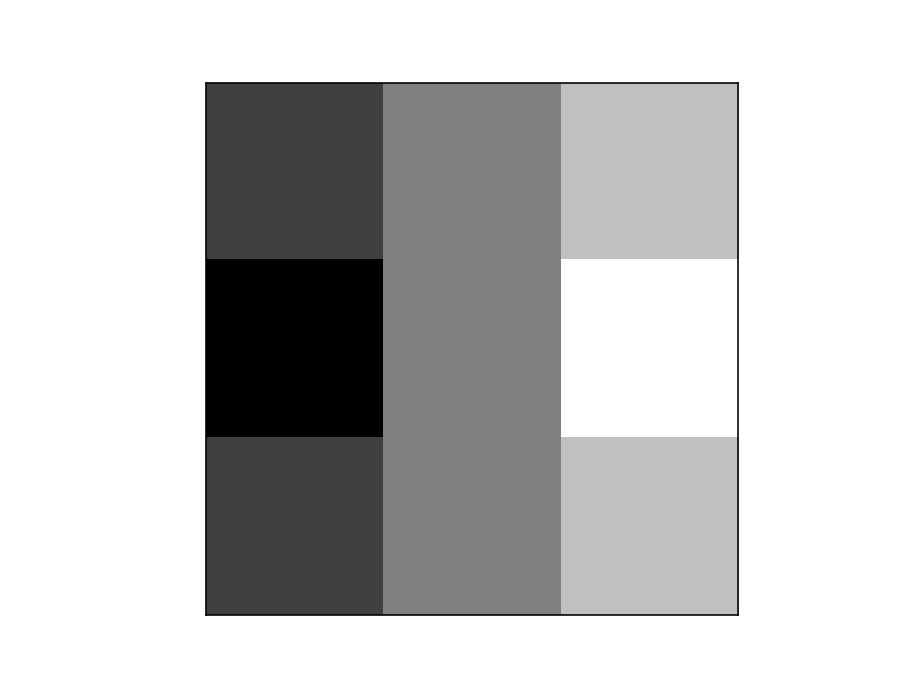
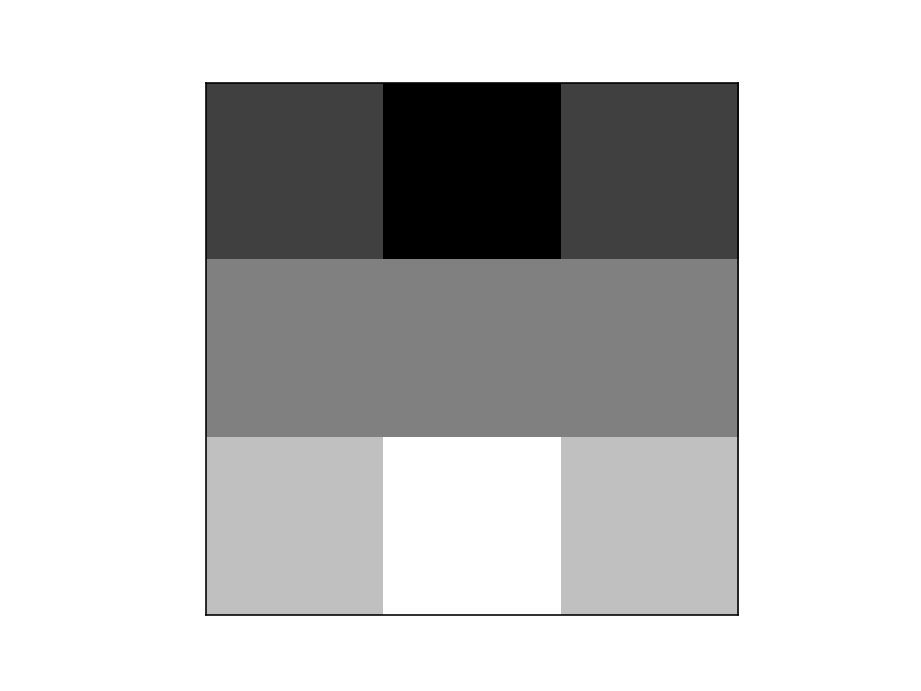
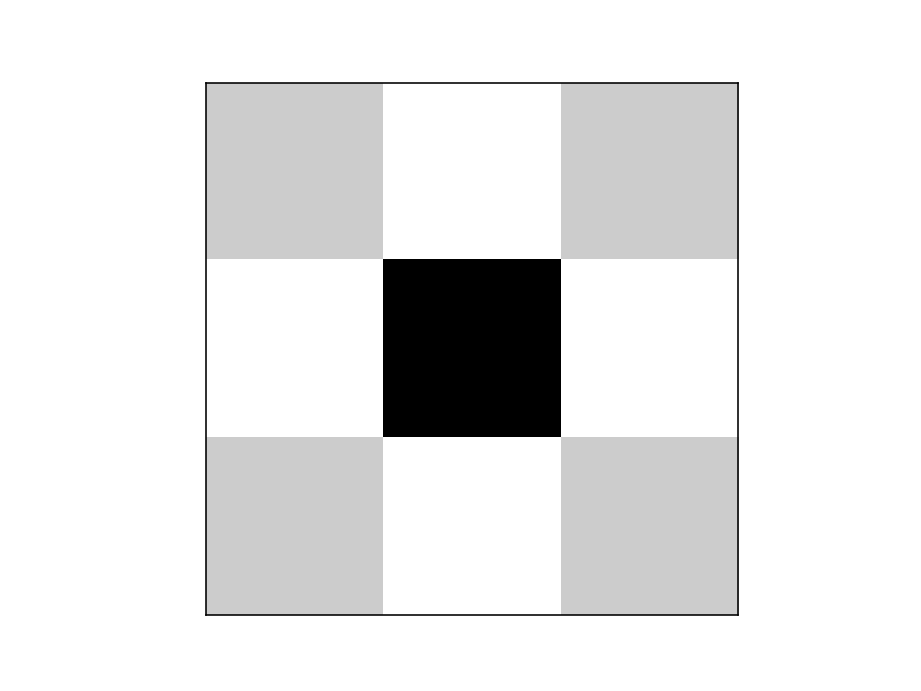
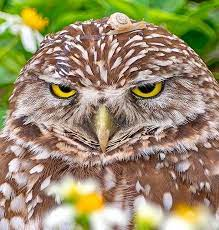
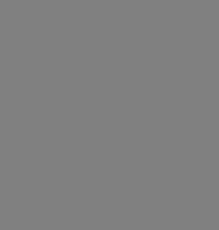
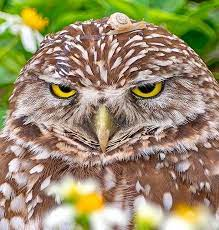
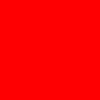
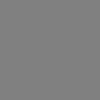
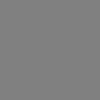
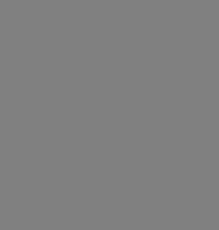
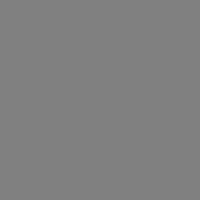
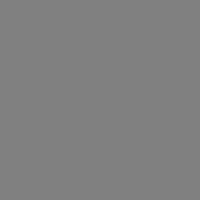
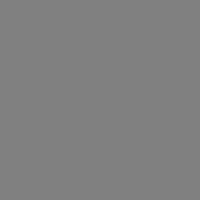
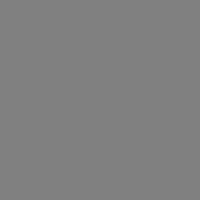

In [288]:
log = []
layout

In [289]:
log

[TypeError("unhashable type: 'list'")]